In [299]:
import pandas as pd
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import datetime
import numpy as np
from IPython import display

In [7]:
df = pd.read_csv('./data_for_week77.csv')
del df['Unnamed: 0']
df['hour_id'] = pd.to_datetime(df['date']).apply(lambda(x): (x-datetime.datetime(2016,5,31,23,0,0)).days*24+(x-datetime.datetime(2016,5,31,23,0,0)).seconds/3600)

In [345]:
target = pd.read_csv('./target (1).csv')
target = target.loc[pd.to_datetime(target.datetime)>=datetime.datetime(2016,6,1,0,0,0),:]
target['hour_id'] = pd.to_datetime(target['datetime']).apply(lambda(x): (x-datetime.datetime(2016,5,31,23,0,0)).days*24+(x-datetime.datetime(2016,5,31,23,0,0)).seconds/3600)
target = pd.DataFrame(binned_statistic_2d(target.hour_id,
                            target['region'], 
                            target['trips'], 
                            'sum', 
                            bins=[range(721), range(1,2502)]).statistic, columns=range(1,2501), 
                        index = [datetime.datetime(2016,6,1,0,0,0)+datetime.timedelta(hours=x) for x in range(720)])
target

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
def prepare_prediction(hour_number):
    a = binned_statistic_2d(df.hour_id,
                            df['region'], 
                            df['h{}'.format(hour_number)], 
                            'sum', 
                            bins=[range(716), range(1,2502)])
    return pd.DataFrame(a.statistic, columns=range(1,2501), 
                        index = [datetime.datetime(2016,5,31,23,0,0)+datetime.timedelta(hours=x) for x in range(715)])

In [246]:
pred1.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [245]:
pred1 = prepare_prediction(1)
pred2 = prepare_prediction(2)
pred3 = prepare_prediction(3)
pred4 = prepare_prediction(4)
pred5 = prepare_prediction(5)
pred6 = prepare_prediction(6)

In [350]:
# задаём константы
longitude_start = -74.25559
longitude_end = -73.70001
latitude_start = 40.49612
latitude_end = 40.91553
nbins = 50
longitude_step = (longitude_end - longitude_start)/nbins
latitude_step = (latitude_end - latitude_start)/nbins

def myplot(hour):
    display.clear_output()
    print(hour)
    print(type(hour))
    # рисуем статическую карту
    
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(18, 14))

    ax = fig.add_subplot(nrows, ncols, 1)
    m = Basemap(llcrnrlon=longitude_start,llcrnrlat=latitude_start,urcrnrlon=longitude_end,urcrnrlat=latitude_end, projection='merc',epsg=2263, resolution='c')
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)

    # задаём сетку
    x, y = np.mgrid[slice(longitude_start, longitude_end+longitude_step/2, longitude_step),
                    slice(latitude_start, latitude_end+latitude_step/2, latitude_step)]
    # задаём значения 
    z = pred1.loc[pred1.index==hour,:].values[0]
    i=0
    zz=[]
    while i<len(z):
      zz.append(z[i:i+nbins])
      i+=nbins
    # раскрашиваем ячейки
    m.pcolormesh (x, y, zz, latlon=True, cmap='OrRd', alpha=0.7)
    plt.colorbar()
    
    
    ax = fig.add_subplot(nrows, ncols, 2)
    m = Basemap(llcrnrlon=longitude_start,llcrnrlat=latitude_start,urcrnrlon=longitude_end,urcrnrlat=latitude_end, projection='merc',epsg=2263, resolution='c')
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)

    # задаём сетку
    x, y = np.mgrid[slice(longitude_start, longitude_end+longitude_step/2, longitude_step),
                    slice(latitude_start, latitude_end+latitude_step/2, latitude_step)]
    # задаём значения 
    z = target.loc[target.index==datetime.datetime.strftime(datetime.datetime.strptime(hour, '%Y-%m-%d %H:%M:%S') + datetime.timedelta(hours=1), '%Y-%m-%d %H:%M:%S'),:].values[0]
    i=0
    zz=[]
    while i<len(z):
      zz.append(z[i:i+nbins])
      i+=nbins
    # раскрашиваем ячейки
    m.pcolormesh (x, y, zz, latlon=True, cmap='OrRd', alpha=0.7)
    plt.colorbar()
    
    plt.show()

In [351]:
class DateRangePicker(object):
    def __init__(self,start,freq='D',fmt='%Y-%m-%d'):
        self.date_range=pd.date_range(start=start,end=datetime.datetime.strptime('2016-06-30 17:00:00', '%Y-%m-%d %H:%M:%S'),freq=freq)
        options = [(item.strftime(fmt),item) for item in self.date_range]
        self.slider_start = widgets.SelectionSlider(
            description='start',
            options=options,
            continuous_update=False
        )

        self.slider_start.on_trait_change(self.slider_start_changed, 'value')

        self.widget = widgets.Box(children=[self.slider_start])

    def slider_start_changed(self,key,value):
        self.slider_start.value=min(self.slider_start.value,datetime.datetime.strptime('2016-06-30 17:00:00', '%Y-%m-%d %H:%M:%S'))
        self._observe(hour=datetime.datetime.strftime(self.slider_start.value, '%Y-%m-%d %H:%M:%S'))
        print(datetime.datetime.strftime(self.slider_start.value, '%Y-%m-%d %H:%M:%S'))


    def display(self):
        display.display(self.slider_start)

    def _observe(self,**kwargs):
        if hasattr(self,'observe'):
            self.observe(**kwargs)

2016-06-25 00:00:00
<type 'str'>
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=913163.164603,120130.315144,1067162.39182,272972.57121&bboxSR=2263&imageSR=2263&size=1500,1488&dpi=96&format=png32&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=913163.164603,120130.315144,1067162.39182,272972.57121&bboxSR=2263&imageSR=2263&size=1500,1488&dpi=96&format=png32&f=image


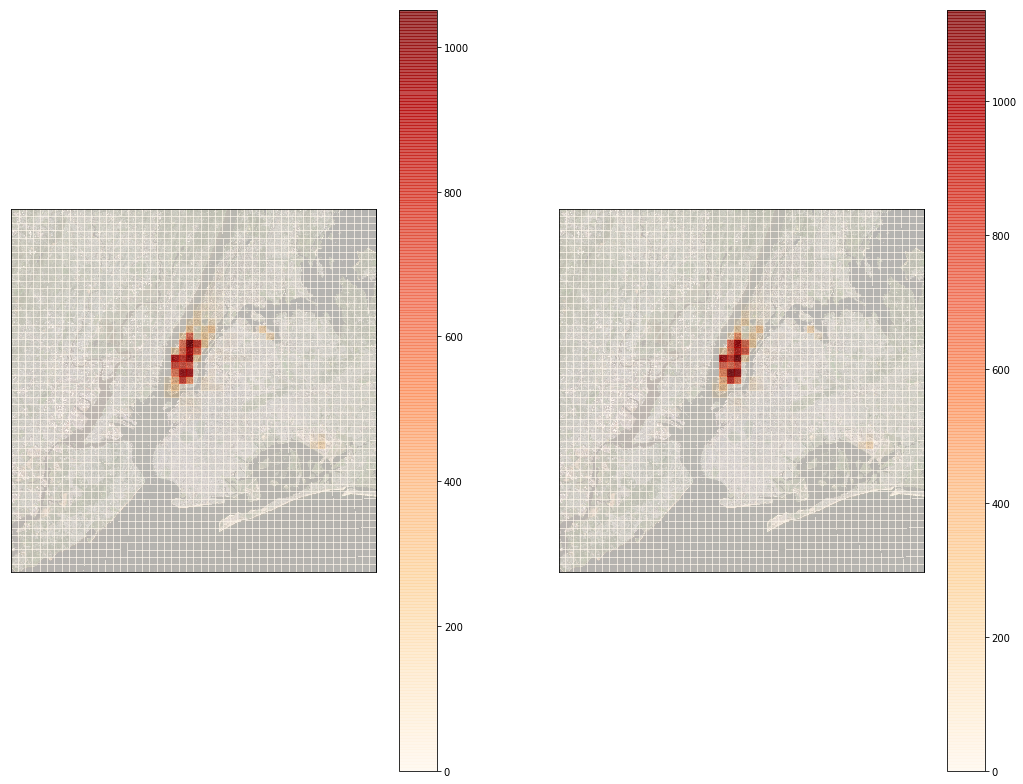

2016-06-25 00:00:00


In [353]:
w=DateRangePicker(start='2016-05-31 23:00:00',freq='H',fmt='%Y-%m-%d %H:%M:%S')
w.observe=myplot
w.display()
